<a href="https://colab.research.google.com/github/Akechi1412/Vietnamese-Review-Classification/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!rm -rf Vietnamese-Review-Classification
!git clone https://github.com/Akechi1412/Vietnamese-Review-Classification
%cd Vietnamese-Review-Classification

Cloning into 'Vietnamese-Review-Classification'...
remote: Enumerating objects: 101, done.
remote: Counting objects: 100% (101/101), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 101 (delta 54), reused 54 (delta 15), pack-reused 0
Receiving objects: 100% (101/101), 18.40 MiB | 37.45 MiB/s, done.
Resolving deltas: 100% (54/54), done.
/content/Vietnamese-Review-Classification/Vietnamese-Review-Classification


In [ ]:
!sudo apt-get install python3.10
!pip install pyvi https://gitlab.com/trungtv/vi_spacy/-/raw/master/packages/vi_core_news_lg-3.6.0/dist/vi_core_news_lg-3.6.0.tar.gz --upgrade

In [22]:
# !git pull origin master

Preparing data...
Data size: 9000
Max number of words: 476
['đọc', 'cuốn', 'sách', 'tập', '1', 'mình', 'đã', 'nhận', 'ra', 'những', 'điều', 'thiếu sót', 'trong', 'quá trình', 'quản trị', 'doanh nghiệp', 'của', 'mình', 'chưa', 'có', 'tầm', 'nhìn', 'sứ mệnh', 'và', 'các', 'giá trị', 'cốt lõi', 'dẫn', 'đến', 'lúng túng', 'và', 'không thể', 'vận hành', 'doanh nghiệp', '1', 'cách', 'trơn tru', 'trong', 'sách', 'còn', 'có', 'nhiều', 'quà', 'tặng', 'đi', 'kèm', 'cực', 'giá trị', 'mình', 'đọc', 'mà', 'quên', 'cả', 'ăn', 'luôn', 'đúng', 'là', 'cuốn', 'sách', 'giá trị', 'trong', 'các', 'cuốn', 'sách', 'mình', 'đã', 'từng', 'đọc']
0


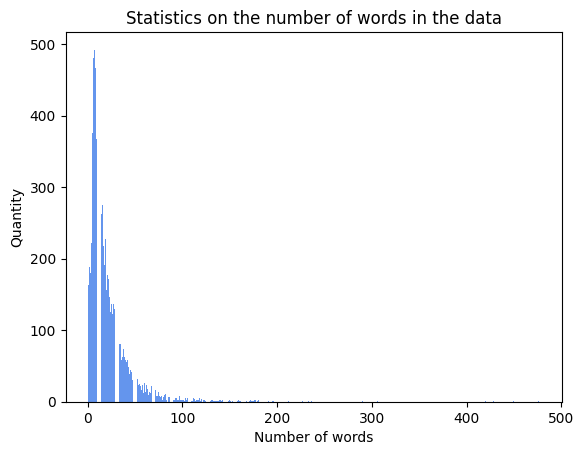

In [23]:
from utils.data_preparing import prepare_data
from utils.plotter import plot_reviews_data

x_data, y_data = prepare_data()

print(f'Data size: {len(x_data)}')
print(f'Max number of words: {len(max(x_data, key=len))}')
print(x_data[0])
print(y_data[0])

plot_reviews_data(x_data)

In [24]:
from sklearn.model_selection import train_test_split

# Split data into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(x_data, y_data, test_size=1/3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(len(x_train), len(y_train))
print(len(x_val), len(y_val))
print(len(x_test), len(y_test))

6000 6000
1500 1500
1500 1500


In [25]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import pickle

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Save tokenize
with open('./models/review_tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

# Pad sequences to ensure uniform length
max_len = 200
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_len)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)

print(f'({len(x_train_pad)}, {len(x_train_pad[0])})')
print(f'({len(x_val_pad)}, {len(x_val_pad[0])})')
print(f'({len(x_test_pad)}, {len(x_test_pad[0])})')

# Create one hot
y_train_one_hot = to_categorical(y_train, num_classes=3)
y_val_one_hot = to_categorical(y_val, num_classes=3)
y_test_one_hot = to_categorical(y_test, num_classes=3)

(6000, 200)
(1500, 200)
(1500, 200)


In [26]:
import numpy as np

x_train_pad = np.array(x_train_pad)
x_val_pad = np.array(x_val_pad)
x_test_pad = np.array(x_test_pad)

y_train_one_hot = np.array(y_train_one_hot)
y_val_one_hot = np.array(y_val_one_hot)
y_test_one_hot = np.array(y_test_one_hot)

In [29]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import ModelCheckpoint

# Build RNN model
model = Sequential()

model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=max_len))
model.add(LSTM(units=64))
model.add(Dense(units=3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Train and save the model,
filepath = './models/review_model.h5'
checkpoint = ModelCheckpoint(
  filepath,
  monitor='val_loss',
  verbose=1,
  save_weights_only=True,
  save_best_only=True,
  mode='min'
)
callbacks_list = [checkpoint]
history = model.fit(
  x_train_pad, y_train_one_hot,
  batch_size=40,
  epochs=10,
  validation_data=(x_val_pad, y_val_one_hot),
  callbacks=callbacks_list
)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 200, 100)          764800    
                                                                 
 lstm_11 (LSTM)              (None, 64)                42240     
                                                                 
 dense_32 (Dense)            (None, 3)                 195       
                                                                 
Total params: 807235 (3.08 MB)
Trainable params: 807235 (3.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 0.7347 - accuracy: 0.6895
Epoch 1: val_loss improved from inf to 0.54434, saving model to ./models/review_model.h5
150/150 [==============================] - 16s 91ms/step - loss: 0.7347 - accuracy: 0.6895 - val

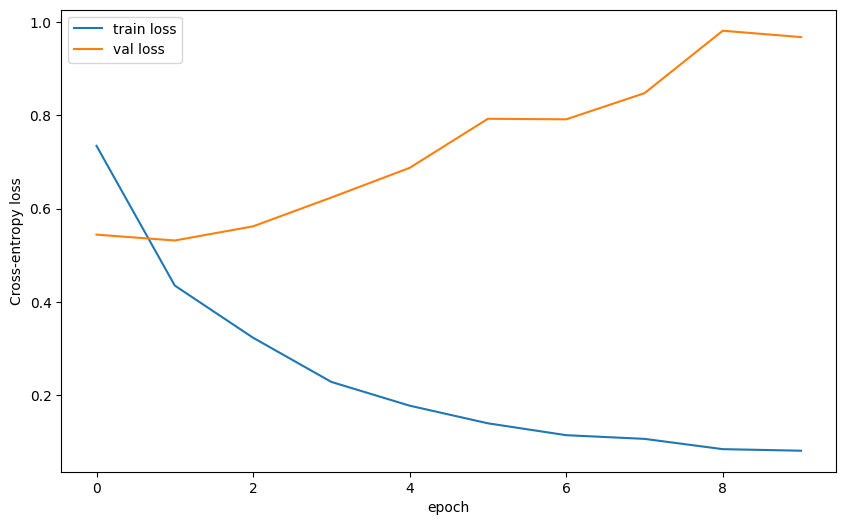

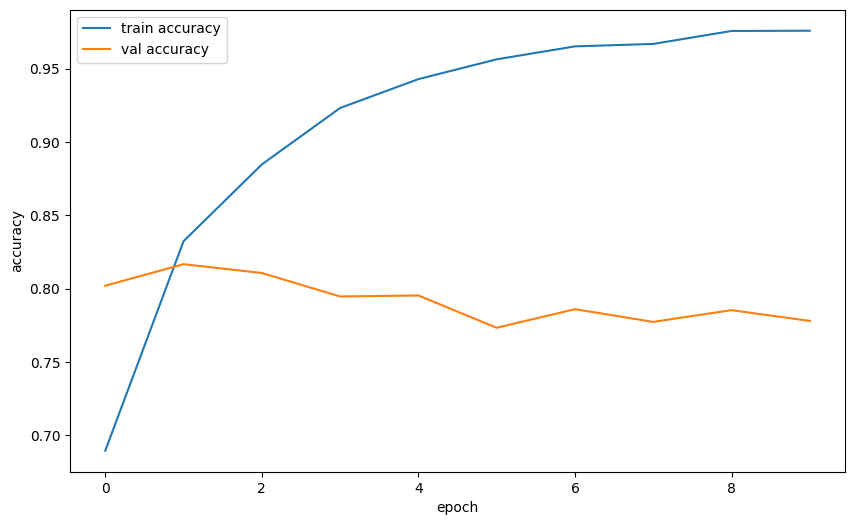

In [30]:
from utils.plotter import plot_history_model

plot_history_model(history)

In [31]:
from sklearn.metrics import confusion_matrix

score, acc = model.evaluate(x_test_pad, y_test_one_hot, batch_size=15, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

y_pred = model.predict(x_test_pad, batch_size=15)
y_test_single = np.argmax(y_test_one_hot, axis=1)
y_pred_single = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test_single, y_pred_single)
print("Confusion Matrix:")
print(conf_matrix)

100/100 - 1s - loss: 0.9240 - accuracy: 0.7880 - 519ms/epoch - 5ms/step
Test score: 0.9239617586135864
Test accuracy: 0.7879999876022339
100/100 [==============================] - 1s 4ms/step
Confusion Matrix:
[[745  32  24]
 [ 70 363  70]
 [ 61  61  74]]
